In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)  # change the data type
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

C:\Users\Andrew\anaconda3\envs\TF_Developer_Certificate\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 3s 126ms/step - loss: 195.6113 - mae: 196.1113 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 58ms/step - loss: 194.8231 - mae: 195.3231 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 54ms/step - loss: 193.5485 - mae: 194.0485 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 57ms/step - loss: 191.9562 - mae: 192.4562 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 55ms/step - loss: 190.0721 - mae: 190.5721 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 58ms/step - loss: 187.8991 - mae: 188.3991 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 56ms/step - loss: 185.4273 - mae: 185.9273 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 60ms/step - loss: 182.5987 - mae: 183.0987 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 58ms/step - loss: 179.3638 - mae:

(1e-08, 0.0001, 0.0, 30.0)

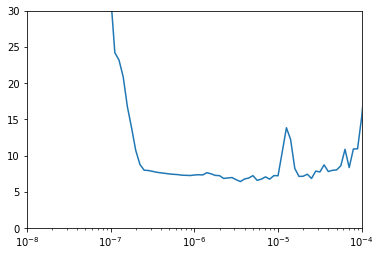

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400, verbose=0)

Epoch 1/400
8/8 [==============================] - 1s 62ms/step - loss: 82.8311 - mae: 83.3310
Epoch 2/400
8/8 [==============================] - 0s 56ms/step - loss: 20.8814 - mae: 21.3756
Epoch 3/400
8/8 [==============================] - 0s 54ms/step - loss: 15.5872 - mae: 16.0798
Epoch 4/400
8/8 [==============================] - 0s 57ms/step - loss: 11.2285 - mae: 11.7179
Epoch 5/400
8/8 [==============================] - 0s 54ms/step - loss: 12.5895 - mae: 13.0816
Epoch 6/400
8/8 [==============================] - 0s 55ms/step - loss: 9.9804 - mae: 10.4693
Epoch 7/400
8/8 [==============================] - 0s 55ms/step - loss: 9.8528 - mae: 10.3450
Epoch 8/400
8/8 [==============================] - 0s 53ms/step - loss: 17.2957 - mae: 17.7909
Epoch 9/400
8/8 [==============================] - 0s 53ms/step - loss: 13.8329 - mae: 14.3240
Epoch 10/400
8/8 [==============================] - 0s 57ms/step - loss: 11.9299 - mae: 12.4242
Epoch 11/400
8/8 [==============================] -

In [32]:
def prediction():
    forecast=[]
    for time in range(len(series) - window_size):
      forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]


    plt.figure(figsize=(10, 6))

    plot_series(time_valid, x_valid)
    plot_series(time_valid, results)

    plt.show()
    print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

    return results


<Figure size 432x288 with 0 Axes>

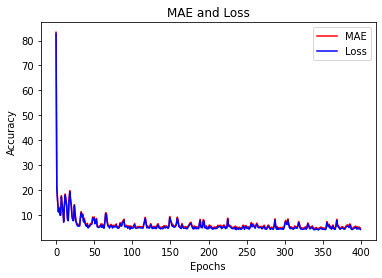

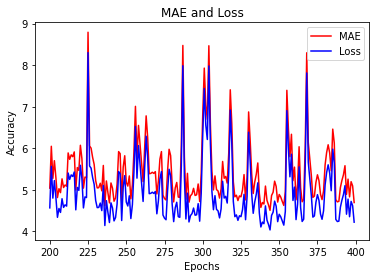

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Coding LSTMs

In [14]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(series, window_size, 128, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model.fit(dataset, epochs=100, verbose=0)

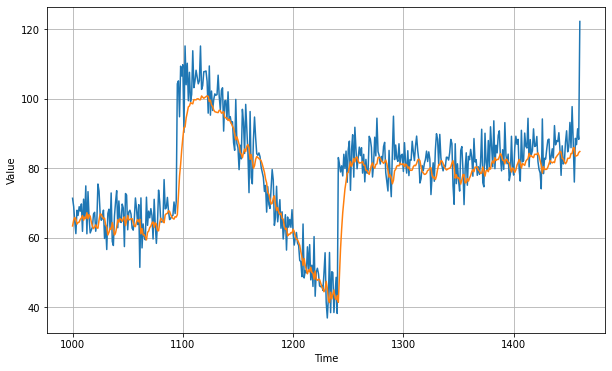

5.331392


In [18]:
prediction()

In [25]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(series, window_size, 128, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: x[..., np.newaxis], input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))

model.fit(dataset, epochs=200, verbose=0)

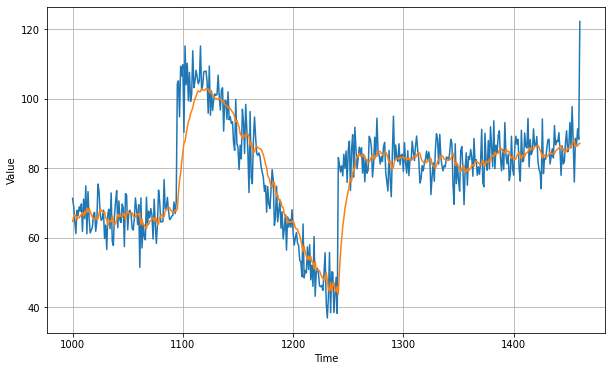

5.206353


In [33]:
fore1 = prediction()